In [ ]:
import sys
sys.path.append('/Users/karl/mrl/')

In [ ]:
from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates import *

//anaconda3/envs/mrl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


In [ ]:
from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *

In [ ]:
from torch.distributions import Normal

In [ ]:
from torch.distributions import VonMises

In [ ]:
d = VonMises(torch.tensor([0., 0.]), torch.tensor([1.0, 1.0]))

In [ ]:
t = d.sample([50])

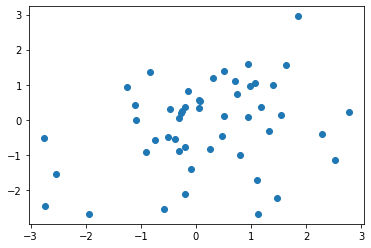

In [ ]:
plt.scatter(t[:,0], t[:,1])

In [ ]:
    res = (torch.sin((1.0-val)*omega)/so).unsqueeze(1)*low + (torch.sin(val*omega)/so).unsqueeze(1) * high


In [ ]:
class SphericalDistribution(torch.distributions.Distribution):
    def __init__(self, loc, scale, validate_args=False):
        super().__init__(loc.shape[0], validate_args=validate_args)
        self.dim = loc.shape[0]
        self.loc = loc
        self.scale = scale
        self.dist = Normal(self.loc, self.scale)
        
    def sample(self, n):
        s = self.dist.sample(n)
        s = F.normalize(s, p=2, dim=-1)
        return s
    
    def rsample(self, n):
        s = self.dist.rsample(n)
        s = F.normalize(s, p=2, dim=-1)
        return s

In [ ]:
d = SphericalDistribution(torch.tensor([5., 5.]), torch.ones((1,)))

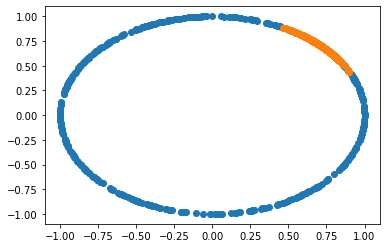

In [ ]:
d1 = SphericalDistribution(torch.tensor([0., 0.]), torch.ones((1,)))
t1 = d1.sample([500])

d2 = SphericalDistribution(torch.tensor([.7, .7]), torch.tensor([0.1, 0.1]))
t2 = d2.sample([500])

plt.scatter(t1[:,0], t1[:,1])
plt.scatter(t2[:,0], t2[:,1])

In [ ]:
d3 = SphericalDistribution(nn.Parameter(torch.tensor([.7, .7])), nn.Parameter(torch.tensor([0.1, 0.1])))
d3.rsample([5])

tensor([[0.7131, 0.7011],
        [0.6645, 0.7473],
        [0.7475, 0.6642],
        [0.6969, 0.7171],
        [0.7259, 0.6878]], grad_fn=<DivBackward0>)

In [ ]:
class HypersphericalUniform(torch.distributions.Distribution):

    support = torch.distributions.constraints.real
    has_rsample = False
    _mean_carrier_measure = 0

    @property
    def dim(self):
        return self._dim

    @property
    def device(self):
        return self._device

    @device.setter
    def device(self, val):
        self._device = val if isinstance(val, torch.device) else torch.device(val)

    def __init__(self, dim, validate_args=None, device="cpu"):
        super(HypersphericalUniform, self).__init__(
            torch.Size([dim]), validate_args=validate_args
        )
        self._dim = dim
        self.device = device

    def sample(self, shape=torch.Size()):
        output = (
            torch.distributions.Normal(0, 1)
            .sample(
                (shape if isinstance(shape, torch.Size) else torch.Size([shape]))
                + torch.Size([self._dim + 1])
            )
            .to(self.device)
        )

        return output / output.norm(dim=-1, keepdim=True)

    def entropy(self):
        return self.__log_surface_area()

    def log_prob(self, x):
        return -torch.ones(x.shape[:-1], device=self.device) * self.__log_surface_area()

    def __log_surface_area(self):
        if torch.__version__ >= "1.0.0":
            lgamma = torch.lgamma(torch.tensor([(self._dim + 1) / 2]).to(self.device))
        else:
            lgamma = torch.lgamma(
                torch.Tensor([(self._dim + 1) / 2], device=self.device)
            )
        return math.log(2) + ((self._dim + 1) / 2) * math.log(math.pi) - lgamma

In [ ]:
d = HypersphericalUniform(1)

//anaconda3/envs/mrl/lib/python3.6/site-packages/torch/distributions/distribution.py:46: UserWarning: <class '__main__.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')


In [ ]:
d.sample(5).pow(2).sum(-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

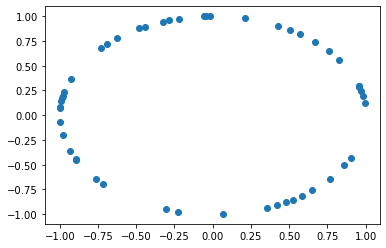

In [ ]:
t = d.sample(50)
plt.scatter(t[:,0], t[:,1])

In [ ]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

developing ideas

turn fp-collate functions into generic latent-collate. this extends fp-latent to property condition latent

redo vae structure. make encoders generic (linear, conv, lstm). all encoders return a single z variable. vae main class handles reparameterication trick and kl calculation. in fact make single layer to convert vector to mu, logvar, to z


encoders:
    map input to vector
        lstm
        conv
        lin
    
transition:
    map vector to latent
        VAE/KL reparameterication
        normaization
        
decoder:
    map latent to output
    
LSTM LM
    no encoder
    zero hiddens
    decoder
    
Conditional LSTM LM
    any encoder
    normalize transition
    lstm decoder
    
vae
    any encoder
    kl-div transition
    

VAE questions

sampling from nothing vs latents vs smiles

best saampling procedure. ie we saample some from latent space (latent to smilles), some from explore straat (smiles to llatent to smilles)

scale of noise on latent

getting log prob of prior vs 

conditional LSTM class - condition on hidden or on decode

torch/models roadmap

torch_core
    tensor operations
    gather
    
dataloaders
    vocab
    dataset
    dataloader

models
    LSTM LM
    VAE
    transformer
    contain supervised training loop
    dataset/dataloader

fastai

move onto torch/models
get protein model running
come back to chem/templates, remake with protein variants. code will hopefully be simpler


get collab working
get google search working

torch core
models (lstm, vae, transformer)
    work in protein stuff here

score functions

training loop

poicy gradients

q-network

diff-loss

exploration strategies

combichem

pharmacophore 


pages
overview

generrative screening primerr